In [1]:
import importlib
import os
import numpy as np
import matplotlib.pyplot as plt
import time
import pandas as pd
from trade_flow_modelling.src.data_management.sign_extractor import sign_extractor
from trade_flow_modelling.src.modelisation.time_series_models import autoregressive_model
from trade_flow_modelling.src.data_management.data_loader.data_loader import load_data
import pyspark.sql.functions as F
from trade_flow_modelling.src.data_management.data_downloader import data_downloader
from statsmodels.tsa.tsatools import lagmat
import statsmodels.api as sm
from statsmodels.tools.tools import pinv_extended
from scipy.optimize import minimize_scalar, milp, brute, minimize
from trade_flow_modelling.src.modelisation.regression import linear_models
from typing import Literal
from trade_flow_modelling.src.modelisation.utils import pyspark_utils

folder_path_key_to_nb_lags_and_time = "/Users/martingangand/Documents/trade_flow_modelling/trade_flow_modelling/src/notebooks/key_to_nb_lags_info"
versions = list(reversed(["statsmodels", "opti", "multi_processes", "scipy_opti_minimize_scalar", "scipy_opti_minimize", "mystic_opti", "perso_opti"]))
version_to_file_name = {version: f"key_to_nb_lags_info_{version}" for version in versions}
extension = ".npy"

def filePath(folder, version, dates, symbols, extension, init_pct=None):
    init_pct_part = f"_init_pct_{init_pct}" if init_pct != None else ""
    return f"{folder}/{dates[0]}_{dates[-1]}_{len(dates)}_{len(symbols)}_{version_to_file_name[version]}{init_pct_part}{extension}"

symbols = ['SOLUSDT', 'XRPUSDT', 'ICPUSDT', 'NEARUSDT', 'DOGEUSDT', 'TRXUSDT', 'IMXUSDT', 'DOTUSDT', 'SHIBUSDT', 'ETCUSDT', 'HBARUSDT', 'BCHUSDT', 'XLMUSDT', 'OOKIUSDT', 'JUVUSDT', 'CITYUSDT']
dates_jan_2024 = [f"2024-01-{i}" for i in range(1, 32)]
dates_feb_2024 = [f"2024-02-{i}" for i in range(1, 30)]

def computeKey(date, symbol):
    date_split = date.split("-")
    # assert(len(date_split) == 3)
    if (len(date_split[-1]) == 1):
        date_split[-1] = f"0{date_split[-1]}"
    date = "".join(date_split)

    return f"{date} {symbol}"

def saveDictionary(dictionary, file_path, allow_pickle=True):
    np.save(file_path, dictionary, allow_pickle=allow_pickle)

def loadDictionary(file_path, allow_pickle=True):
    dictionary = np.load(file_path, allow_pickle=allow_pickle).item()
    return dictionary

def fileExist(file_path):
    return os.path.isfile(file_path)

PYSPARK_UTILS
DATES_UTILS
DATES TYPES
DATA_LOADER
SYMBOLS
DATA_DOWNLOADER


In [5]:
# start_date = dates_jan_2024[0]
# end_date = dates_feb_2024[-1]

# print(f"Dowloading data from {start_date} to {end_date} for {len(symbols)} symbols\n")
# print(f"    0 %", end="")
# nb_success = 0
# for i, symbol in enumerate(symbols):
#     try:
#         data_downloader.download_data(symbol, "daily", start_date, end_date, verbose=False)
#         nb_success += 1
#         percentage = round(100 * (i + 1) / len(symbols))
#         print(f" => {percentage} %", end="" if percentage != 100 else f"\n\n")
#     except Exception as e:
#         print(f"Problem encountered to download data for {symbol} from {start_date} to {end_date}")
#         print(e)
# print(f"Nb success: {nb_success}/{len(symbols)} symbols")

Dowloading data from 2024-01-1 to 2024-02-29 for 16 symbols

    0 % => 6 % => 12 % => 19 % => 25 % => 31 % => 38 % => 44 % => 50 % => 56 % => 62 % => 69 % => 75 % => 81 % => 88 % => 94 % => 100 %

Nb success: 16/16 symbols


In [3]:
def load_data_several_symbols(symbols, date_type_periodicity, start_date, end_date, sort_column = ["time", "id"]):
    data_all_symbols = None
    for symbol in symbols:
        data = load_data(symbol, date_type_periodicity, start_date, end_date, sort_column).withColumn("sym", F.lit(symbol))
        data_all_symbols = data_all_symbols.union(data) if data_all_symbols is not None else data

    columns_without_sym = data_all_symbols.columns
    columns_without_sym.remove("sym")
    data_all_symbols = data_all_symbols.select(["sym"] + columns_without_sym)
    return data_all_symbols

def sortSymbolsByMedianNbTrades(start_date, end_date, symbols):
    data = load_data_several_symbols(symbols, "daily", start_date, end_date)

    date_sym_nb_trades = data.groupBy(F.col("date"), F.col("sym")).agg(F.count(F.col("time")).alias("nb_trades"))
    sym_stats = date_sym_nb_trades.groupBy(F.col("sym")).agg(F.round(F.median(F.col("nb_trades"))).alias("median"), F.round(F.mean(F.col("nb_trades"))).alias("mean")).sort(F.desc("median"))

    sorted_symbols = pyspark_utils.get_column_from_pyspark_df(sym_stats, "sym")
    medians = pyspark_utils.get_column_from_pyspark_df(sym_stats, "median")
    assert(len(sorted_symbols) == len(symbols))
    return sorted_symbols, medians

# sorted_symbols, medians = sortSymbolsByMedianNbTrades(dates_jan_2024[0], dates_feb_2024[-1], symbols)
# print(sorted_symbols)
# print()
# for i, (sym, median) in enumerate(zip(sorted_symbols, medians)):
#     print(f"{i + 1}. {sym} (median: {median})")

In [3]:
# Compute nb_lags, time taken and nb_signs for a given version

def computeNbLagsInfo(dates, symbols, version: Literal["statsmodels", "opti", "multi_processes", "scipy_opti_minimize_scalar", "scipy_opti_minimize", "mystic_opti", "perso_opti"], nb_signs_max=None, init_pct=1, idx_start=0, save=False, verbose=False):
    s = time.time()
    assert(version in version_to_file_name)
    file_path = filePath(folder_path_key_to_nb_lags_and_time, version, dates, symbols, extension, init_pct)

    if (verbose):
        print(f"{'*' * 25} START {version} (init_pct: {init_pct}) {'*' * 25}")
        print(f"{len(dates)} dates and {len(symbols)} symbols")

    key_to_nb_lags_info = {}
    for i in range(idx_start, len(symbols)):
        symbol = symbols[i]
        if (verbose):
            print(f"    {symbol} ({i + 1}/{len(symbols)})")
            print(f"    0 %", end="")

        if (fileExist(file_path)):
            key_to_nb_lags_info = loadDictionary(file_path)

        for j, date in enumerate(dates):
            signs = sign_extractor.retrieve_signs(symbol, date, date)
            if (nb_signs_max is not None):
                signs = signs[:nb_signs_max]
            ar_model = autoregressive_model.AutoregressiveModel(signs, nb_lags=None)
            s = time.time()
            nb_lags = ar_model.select_model_nb_lags(version, nb_processes=4, init_pct=init_pct)
            e = time.time()

            key = computeKey(date, symbol)
            assert(key not in key_to_nb_lags_info)
            key_to_nb_lags_info[key] = (nb_lags, e - s, len(signs)) # (nb_lags, time, nb_signs)
            if (verbose):
                percentage = round(100 * (j + 1) / len(dates))
                print(f" => {percentage} %", end="" if percentage != 100 else f"\n\n")
        if (save):
            saveDictionary(key_to_nb_lags_info, file_path, allow_pickle=True)
            print(f"    updated nb_lags info (len(dic): {len(key_to_nb_lags_info.keys())}) for {version} in {file_path}")
        
    # assert(len(key_to_nb_lags_info) == len(dates) * len(symbols))
    e = time.time()

    if (verbose):
        print(f"End {version} for {len(dates)} dates and {len(symbols)} symbols")
        print(f"{'*' * 20} END ({round(e - s, 2)} s) {'*' * 20}\n")
        
    return key_to_nb_lags_info

In [4]:
# Compute nb_lags info for different version with several dates and symbols

versions_restricted = ["multi_processes"]
# versions_restricted = ["mystic_opti"]
# versions_restricted = ["multi_processes", "scipy_opti_minimize", "mystic_opti"]
dates = dates_jan_2024 + dates_feb_2024
symbols = symbols
init_pcts_ref = [2.0]
# init_pcts_ref = [0, 0.2, 0.4, 0.6, 0.8, 1.0, 1.25, 2.0]

print(f"START ({len(dates)} dates | {len(symbols)} symbols)")
nb_success = 0
for version in versions_restricted:
    init_pcts = init_pcts_ref if version == "mystic_opti" else [None]
    for init_pct in init_pcts:
        try:
            # init_pct = init_pct if version != "multi_processes" else None
            key_to_nb_lags_info = computeNbLagsInfo(dates, symbols, version, nb_signs_max=260000, init_pct=init_pct, idx_start=0, save=True, verbose=True)
            nb_success += 1
        except Exception as e:
            print(f"\n!!! Problem happened for version {version} !!!")
            print(e)
        finally:
            if (version != versions[-1]):
                time.sleep(5)

print(f"SUMMARY: {nb_success}/{len(versions) * len(init_pcts)} success")

START (60 dates | 16 symbols)
************************* START multi_processes (init_pct: None) *************************
60 dates and 14 symbols
    ICPUSDT (1/14)
    0 %

24/03/22 06:58:07 WARN Utils: Your hostname, Martins-MacBook-Air-3.local resolves to a loopback address: 127.0.0.1, but we couldn't find any external IP address!
24/03/22 06:58:07 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/03/22 06:58:08 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Java HotSpot(TM) 64-Bit Server VM warning: CodeCache is full. Compiler has been disabled.
Java HotSpot(TM) 64-Bit Server VM warning: Try increasing the code cache size using -XX:ReservedCodeCacheSize=


CodeCache: size=131072Kb used=20480Kb max_used=20836Kb free=110591Kb
 bounds [0x000000010a9e0000, 0x000000010be70000, 0x00000001129e0000]
 total_blobs=8342 nmethods=7414 adapters=840
 compilation: disabled (not enough contiguous free space left)


 => 2 %

 => 3 %

 => 5 % => 7 % => 8 % => 10 % => 12 % => 13 % => 15 % => 17 % => 18 % => 20 % => 22 % => 23 % => 25 % => 27 % => 28 % => 30 % => 32 % => 33 % => 35 % => 37 % => 38 % => 40 % => 42 % => 43 % => 45 % => 47 % => 48 % => 50 % => 52 % => 53 % => 55 % => 57 % => 58 % => 60 % => 62 % => 63 % => 65 % => 67 % => 68 % => 70 % => 72 % => 73 % => 75 % => 77 % => 78 % => 80 % => 82 % => 83 % => 85 % => 87 % => 88 % => 90 % => 92 % => 93 % => 95 % => 97 % => 98 % => 100 %

    updated nb_lags info (len(dic): 180) for multi_processes in /Users/martingangand/Documents/trade_flow_modelling/trade_flow_modelling/src/notebooks/key_to_nb_lags_info/2024-01-1_2024-02-29_60_16_key_to_nb_lags_info_multi_processes.npy
    NEARUSDT (2/14)
    0 % => 2 % => 3 % => 5 % => 7 % => 8 % => 10 % => 12 % => 13 % => 15 % => 17 % => 18 % => 20 % => 22 % => 23 % => 25 % => 27 % => 28 % => 30 % => 32 % => 33 % => 35 % => 37 % => 38 % => 40 % => 42 % => 43 % => 45 % => 47 % => 48 % => 50 % => 52 % => 53 % => 55 % => 57 % => 

 => 98 %

 => 100 %

    updated nb_lags info (len(dic): 300) for multi_processes in /Users/martingangand/Documents/trade_flow_modelling/trade_flow_modelling/src/notebooks/key_to_nb_lags_info/2024-01-1_2024-02-29_60_16_key_to_nb_lags_info_multi_processes.npy
    TRXUSDT (4/14)
    0 % => 2 % => 3 % => 5 % => 7 % => 8 % => 10 % => 12 % => 13 % => 15 % => 17 % => 18 % => 20 % => 22 % => 23 % => 25 % => 27 % => 28 % => 30 % => 32 % => 33 % => 35 % => 37 % => 38 % => 40 % => 42 % => 43 % => 45 % => 47 % => 48 % => 50 % => 52 % => 53 % => 55 % => 57 % => 58 % => 60 % => 62 % => 63 % => 65 % => 67 % => 68 % => 70 % => 72 % => 73 % => 75 % => 77 % => 78 % => 80 % => 82 % => 83 % => 85 % => 87 % => 88 % => 90 % => 92 % => 93 % => 95 % => 97 % => 98 % => 100 %

    updated nb_lags info (len(dic): 360) for multi_processes in /Users/martingangand/Documents/trade_flow_modelling/trade_flow_modelling/src/notebooks/key_to_nb_lags_info/2024-01-1_2024-02-29_60_16_key_to_nb_lags_info_multi_processes.npy
    IMXUS

 => 100 %

    updated nb_lags info (len(dic): 540) for multi_processes in /Users/martingangand/Documents/trade_flow_modelling/trade_flow_modelling/src/notebooks/key_to_nb_lags_info/2024-01-1_2024-02-29_60_16_key_to_nb_lags_info_multi_processes.npy
    ETCUSDT (8/14)
    0 % => 2 % => 3 % => 5 % => 7 % => 8 % => 10 % => 12 % => 13 % => 15 % => 17 % => 18 % => 20 % => 22 % => 23 % => 25 % => 27 % => 28 % => 30 % => 32 % => 33 % => 35 % => 37 % => 38 % => 40 % => 42 % => 43 % => 45 % => 47 % => 48 % => 50 % => 52 % => 53 % => 55 % => 57 % => 58 % => 60 % => 62 % => 63 % => 65 % => 67 % => 68 % => 70 % => 72 % => 73 % => 75 % => 77 % => 78 % => 80 % => 82 % => 83 % => 85 % => 87 % => 88 % => 90 % => 92 % => 93 % => 95 % => 97 % => 98 % => 100 %

    updated nb_lags info (len(dic): 600) for multi_processes in /Users/martingangand/Documents/trade_flow_modelling/trade_flow_modelling/src/notebooks/key_to_nb_lags_info/2024-01-1_2024-02-29_60_16_key_to_nb_lags_info_multi_processes.npy
    HBARU

In [56]:
def retrieve_nb_lags_info_from_dic(dic, date, symbol, info_to_retrieve: Literal["nb_lags", "time", "nb_signs"]):
    info_to_idx = {"nb_lags": 0, "time": 1, "nb_signs": 2}
    assert(info_to_retrieve in info_to_idx)

    key = computeKey(date, symbol)
    if (not key in dic):
        print(f"No date found for {date} {symbol}")
    else:
        element_idx = info_to_idx[info_to_retrieve]
        return dic.get(key)[element_idx]
    
def sortSymbolByMedianNbTrades(symbol_to_nb_signs_per_day):
    sorted_items = sorted(symbol_to_nb_signs_per_day.items(), key=lambda item: np.median(item[1]), reverse=True)
    sorted_symbols = [symbol for (symbol, _) in sorted_items]
    return sorted_symbols

def retrieve_dates_symbols(dic_1, dic_2):
    assert(len(dic_1) == len(dic_2))

    dates = set()
    symbols = set()
    symbol_to_nb_signs_per_day = {}
    for key in dic_1.keys():
        assert(key in dic_2)
        date, symbol = key.split(" ")
        dates.add(date)
        symbols.add(symbol)
        symbol_to_nb_signs_per_day[symbol] = symbol_to_nb_signs_per_day.get(symbol, []) + [retrieve_nb_lags_info_from_dic(dic_1, date, symbol, "nb_signs")]
    
    sorted_symbols = sortSymbolByMedianNbTrades(symbol_to_nb_signs_per_day)
    for symbol in symbols:
        assert(symbol in sorted_symbols)
    
    assert(len(dic_1) == len(dates) * len(sorted_symbols))
    return sorted(list(dates)), sorted_symbols


In [70]:
def compare_ar_selection_versions(dic_1, dic_2, first_n_symbols=None):
    dates, symbols = retrieve_dates_symbols(dic_1, dic_2)
    
    if (first_n_symbols is not None):
        symbols = symbols[:first_n_symbols]

    global_count_nb_lags_correct = 0
    abs_diff_nb_lags_when_incorrect = []
    diff_nb_lags_when_incorrect = []
    symbol_to_count_nb_lags_correct = {}
    ref_nb_lags_list = []
    other_nb_lags_list = []
    symbol_to_abs_diff_nb_lags_when_incorrect = {}
    symbol_to_diff_nb_lags_when_incorrect = {}
    symbol_to_nb_signs_per_day = {}
    total_time_ref = 0
    total_time_other = 0
    symbol_to_total_time = {}
    ref_time_list = []
    other_time_list = []

    for symbol in symbols:
        symbol_to_count_nb_lags_correct[symbol] = 0
        symbol_to_nb_signs_per_day[symbol] = []
        symbol_to_abs_diff_nb_lags_when_incorrect[symbol] = []
        symbol_to_diff_nb_lags_when_incorrect[symbol] = []
        symbol_to_total_time[symbol] = [0, 0] # [ref_time, other_time]
        for date in dates:
            key = computeKey(date, symbol)
            assert(key in dic_1 and key in dic_2)

            ref_nb_lags = retrieve_nb_lags_info_from_dic(dic_1, date, symbol, "nb_lags")
            other_nb_lags = retrieve_nb_lags_info_from_dic(dic_2, date, symbol, "nb_lags")
            global_count_nb_lags_correct += 1 if ref_nb_lags == other_nb_lags else 0
            symbol_to_count_nb_lags_correct[symbol] += 1 if ref_nb_lags == other_nb_lags else 0
            abs_diff_nb_lags_when_incorrect += [np.abs(ref_nb_lags - other_nb_lags)] if ref_nb_lags != other_nb_lags else []
            diff_nb_lags_when_incorrect += [ref_nb_lags - other_nb_lags] if ref_nb_lags != other_nb_lags else []
            symbol_to_abs_diff_nb_lags_when_incorrect[symbol] += [np.abs(ref_nb_lags - other_nb_lags)] if ref_nb_lags != other_nb_lags else []
            symbol_to_diff_nb_lags_when_incorrect[symbol] += [ref_nb_lags - other_nb_lags] if ref_nb_lags != other_nb_lags else []

            ref_nb_signs = retrieve_nb_lags_info_from_dic(dic_1, date, symbol, "nb_signs")
            other_nb_signs = retrieve_nb_lags_info_from_dic(dic_2, date, symbol, "nb_signs")
            assert(ref_nb_signs == other_nb_signs)
            symbol_to_nb_signs_per_day[symbol].append(ref_nb_signs)

            ref_time = retrieve_nb_lags_info_from_dic(dic_1, date, symbol, "time")
            other_time = retrieve_nb_lags_info_from_dic(dic_2, date, symbol, "time")
            total_time_ref += ref_time
            total_time_other += other_time
            symbol_to_total_time[symbol][0] += ref_time
            symbol_to_total_time[symbol][1] += other_time
    
    position_correct_nb_lags = []
    for i, symbol in enumerate(symbols):
        for j, date in enumerate(dates):
            ref_nb_lags = retrieve_nb_lags_info_from_dic(dic_1, date, symbol, "nb_lags")
            other_nb_lags = retrieve_nb_lags_info_from_dic(dic_2, date, symbol, "nb_lags")
            ref_nb_lags_list.append(ref_nb_lags)
            other_nb_lags_list.append(other_nb_lags)
            if (ref_nb_lags == other_nb_lags):
                position_correct_nb_lags.append(i * (len(dates)) + j)

            ref_time = retrieve_nb_lags_info_from_dic(dic_1, date, symbol, "time")
            other_time = retrieve_nb_lags_info_from_dic(dic_2, date, symbol, "time")
            ref_time_list.append(ref_time)
            other_time_list.append(other_time)

    global_percentage_nb_lags_correct = 100 * global_count_nb_lags_correct / (len(dates) * len(symbols))
    print(f"{'*' * 25} Analysis of version 1 vs version 2 {'*' * 25}")
    print(f"{'*' * 15} A. COMPARISON OF: nb_lags {'*' * 15}")
    print(f"1. Global percentage of correct nb_lags for version 2: {round(global_percentage_nb_lags_correct, 2)} % ({global_count_nb_lags_correct}/{len(dates) * len(symbols)}) (detail per symbol below)")
    for symbol in symbols:
        percentage_nb_lags_correct = 100 * symbol_to_count_nb_lags_correct[symbol] / len(dates)
        print(f"    {symbol}: {round(percentage_nb_lags_correct, 2)} % ({symbol_to_count_nb_lags_correct[symbol]}/{len(dates)}) (avg nb_signs: {round(np.mean(symbol_to_nb_signs_per_day[symbol]))} | med nb_signs: {round(np.median(symbol_to_nb_signs_per_day[symbol]))})")

    print(f"\n2. Plot version 1 nb_lags vs version 2 nb_lags")
    fig, axe = plt.subplots(1, 1, figsize=(21, 4))
    axe.plot(ref_nb_lags_list, color="green", label="Version 1 nb_lags", marker="o")
    axe.plot(other_nb_lags_list, color="orange", label="Version 2 nb_lags", marker="o")
    for i, position_correct in enumerate(position_correct_nb_lags):
        axe.plot(position_correct, ref_nb_lags_list[position_correct], color="purple", label="Correct nb_lags" if i == 0 else None, marker = 'x')
    for i in range(len(symbols) - 1):
        axe.axvline(x=(len(dates) - 1) * (i + 1), color='grey', label="Symbol change" if i == 0 else None, linestyle='--')
    axe.set_title("Version 1 nb_lags (green) vs version 2 nb_lags (orange) per key")
    axe.set_xlabel("Key")
    axe.set_ylabel("nb_lags")
    axe.legend()
    plt.show()

    print(f"\n3. Average difference of nb_lags when incorrect: {round(np.mean(abs_diff_nb_lags_when_incorrect), 2) if len(abs_diff_nb_lags_when_incorrect) > 0 else 0} (abs) | {round(np.mean(diff_nb_lags_when_incorrect), 2) if len(diff_nb_lags_when_incorrect) > 0 else 0} (signed) | std: {round(np.std(diff_nb_lags_when_incorrect), 2) if len(diff_nb_lags_when_incorrect) > 0 else 0} | (detail per symbol below)")
    for symbol in symbols:
        avg_abs_diff_nb_lags_when_incorrect = np.mean(symbol_to_abs_diff_nb_lags_when_incorrect[symbol]) if len(symbol_to_abs_diff_nb_lags_when_incorrect[symbol]) > 0 else 0
        avg_diff_nb_lags_when_incorrect = np.mean(symbol_to_diff_nb_lags_when_incorrect[symbol]) if len(symbol_to_diff_nb_lags_when_incorrect[symbol]) > 0 else 0
        std_diff_nb_lags_when_incorrect = np.std(symbol_to_diff_nb_lags_when_incorrect[symbol]) if len(symbol_to_diff_nb_lags_when_incorrect[symbol]) > 0 else 0
        print(f"    {symbol}: {round(avg_abs_diff_nb_lags_when_incorrect, 2)} (abs) | {round(avg_diff_nb_lags_when_incorrect, 2)} (signed) | std: {round(std_diff_nb_lags_when_incorrect, 2)}")

    print(f"\n\n{'*' * 15} B. COMPARISON OF: time {'*' * 15}")
    total_percentage_diff_time = 100 * ((total_time_other / total_time_ref) - 1)
    print(f"4. Total ref time: {round(total_time_ref, 2)} s | total other time: {round(total_time_other, 2)} s ({'+' if total_percentage_diff_time > 0 else '-'}{round(abs(total_percentage_diff_time), 2)} %) (detail per symbol below)")

    for symbol in symbols:
        percentage_diff_time = 100 * ((symbol_to_total_time[symbol][1] / symbol_to_total_time[symbol][0]) - 1)
        print(f"    {symbol}: {round(symbol_to_total_time[symbol][0], 2)} s (ref) | {round(symbol_to_total_time[symbol][1], 2)} s (other) ({'+' if percentage_diff_time > 0 else '-'}{round(abs(percentage_diff_time), 2)} %)")

    print("\n5. Plot version 1 time vs version 2 time")
    fig, axe = plt.subplots(1, 1, figsize=(21, 4))
    axe.plot(ref_time_list, color="green", label="Version 1 time", marker="o")
    axe.plot(other_time_list, color="orange", label="Version 2 time", marker="o")
    for i in range(len(symbols) - 1):
        axe.axvline(x=(len(dates) - 1) * (i + 1), color='grey', label="Symbol change" if i == 0 else None, linestyle='--')
    axe.set_title("Version 1 time (green) vs version 2 time (orange) per key")
    axe.set_xlabel("Key")
    axe.set_ylabel("time (seconds)")
    axe.legend()
    plt.show()

In [49]:
versions = ["multi_processes", "scipy_opti_minimize", "mystic_opti"]

dates = dates_jan_2024 + dates_feb_2024

dic_ref = loadDictionary(filePath(folder_path_key_to_nb_lags_and_time, "multi_processes", dates, symbols, extension))
dic_scipy_opti_minimize = loadDictionary(filePath(folder_path_key_to_nb_lags_and_time, "scipy_opti_minimize", dates, symbols, extension))
dic_mystic_opti_0 = loadDictionary(filePath(folder_path_key_to_nb_lags_and_time, "mystic_opti", dates, symbols, extension, 0))
dic_mystic_opti_0_2 = loadDictionary(filePath(folder_path_key_to_nb_lags_and_time, "mystic_opti", dates, symbols, extension, 0.2))
dic_mystic_opti_0_4 = loadDictionary(filePath(folder_path_key_to_nb_lags_and_time, "mystic_opti", dates, symbols, extension, 0.4))
dic_mystic_opti_0_6 = loadDictionary(filePath(folder_path_key_to_nb_lags_and_time, "mystic_opti", dates, symbols, extension, 0.6))
dic_mystic_opti_0_8 = loadDictionary(filePath(folder_path_key_to_nb_lags_and_time, "mystic_opti", dates, symbols, extension, 0.8))
dic_mystic_opti_1 = loadDictionary(filePath(folder_path_key_to_nb_lags_and_time, "mystic_opti", dates, symbols, extension, 1.0))
dic_mystic_opti_1_25 = loadDictionary(filePath(folder_path_key_to_nb_lags_and_time, "mystic_opti", dates, symbols, extension, 1.25))
dic_mystic_opti_2 = loadDictionary(filePath(folder_path_key_to_nb_lags_and_time, "mystic_opti", dates, symbols, extension, 2.0))

************************* Analysis of version 1 vs version 2 *************************
*************** A. COMPARISON OF: nb_lags ***************
1. Global percentage of correct nb_lags for version 2: 49.33 % (148/300) (detail per symbol below)
    SOLUSDT: 86.67 % (52/60) (avg nb_signs: 259495 | med nb_signs: 260000)
    XRPUSDT: 55.0 % (33/60) (avg nb_signs: 185406 | med nb_signs: 181975)
    ICPUSDT: 33.33 % (20/60) (avg nb_signs: 185348 | med nb_signs: 170671)
    NEARUSDT: 28.33 % (17/60) (avg nb_signs: 139545 | med nb_signs: 120020)
    DOGEUSDT: 43.33 % (26/60) (avg nb_signs: 145490 | med nb_signs: 119447)

2. Plot version 1 nb_lags vs version 2 nb_lags


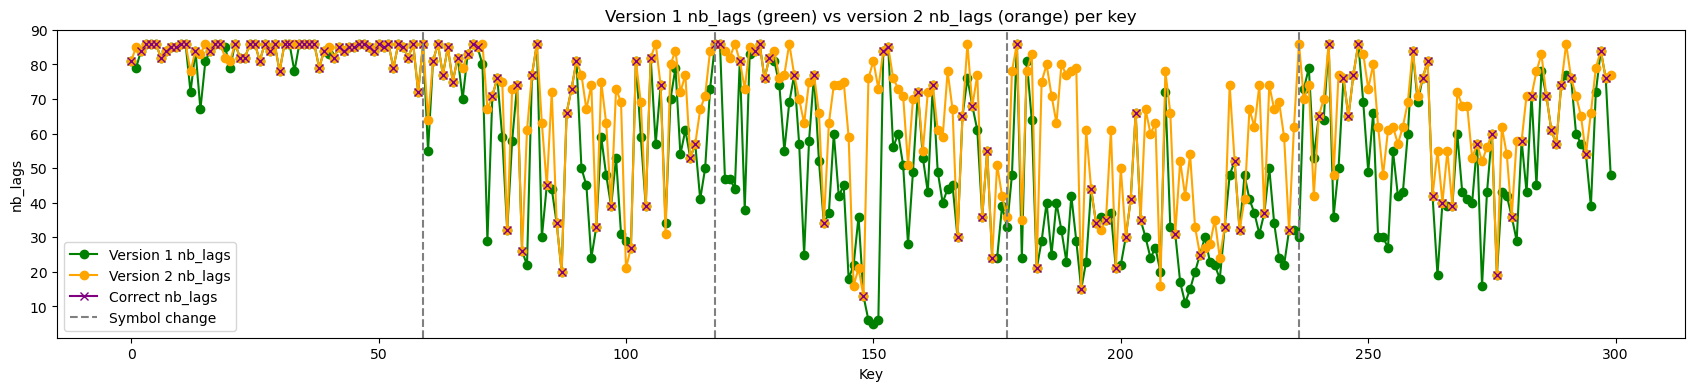


3. Average difference of nb_lags when incorrect: 21.78 (abs) | -20.79 (signed) | std: 16.32 | (detail per symbol below)
    SOLUSDT: 6.0 (abs) | -5.25 (signed) | std: 5.17
    XRPUSDT: 19.93 (abs) | -19.11 (signed) | std: 13.12
    ICPUSDT: 23.95 (abs) | -22.9 (signed) | std: 18.93
    NEARUSDT: 26.47 (abs) | -24.6 (signed) | std: 18.68
    DOGEUSDT: 18.47 (abs) | -18.47 (signed) | std: 9.87


*************** B. COMPARISON OF: time ***************
4. Total ref time: 10523.22 s | total other time: 1400.54 s (-86.69 %) (detail per symbol below)
    SOLUSDT: 4808.48 s (ref) | 388.49 s (other) (-91.92 %)
    XRPUSDT: 3064.02 s (ref) | 298.11 s (other) (-90.27 %)
    ICPUSDT: 1102.32 s (ref) | 294.66 s (other) (-73.27 %)
    NEARUSDT: 733.61 s (ref) | 217.34 s (other) (-70.37 %)
    DOGEUSDT: 814.79 s (ref) | 201.95 s (other) (-75.21 %)

5. Plot version 1 time vs version 2 time


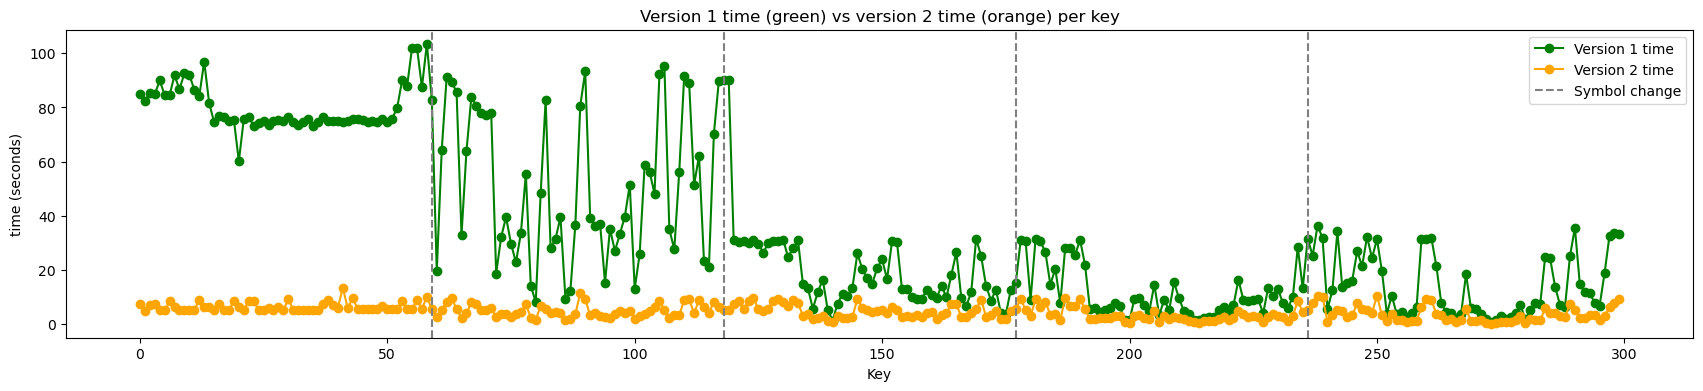

In [93]:
symbol_to_nb_signs_per_day = compare_ar_selection_versions(dic_ref, dic_mystic_opti_2, first_n_symbols=5)

************************* Analysis of version 1 vs version 2 *************************
*************** A. COMPARISON OF: nb_lags ***************
1. Global percentage of correct nb_lags for version 2: 43.23 % (415/960) (detail per symbol below)
    XRPUSDT: 55.0 % (33/60) (avg nb_signs: 185406 | med nb_signs: 181975)
    OOKIUSDT: 43.33 % (26/60) (avg nb_signs: 17019 | med nb_signs: 11236)
    SOLUSDT: 86.67 % (52/60) (avg nb_signs: 259495 | med nb_signs: 260000)
    BCHUSDT: 43.33 % (26/60) (avg nb_signs: 63806 | med nb_signs: 40690)
    DOGEUSDT: 43.33 % (26/60) (avg nb_signs: 145490 | med nb_signs: 119447)
    JUVUSDT: 35.0 % (21/60) (avg nb_signs: 11313 | med nb_signs: 9041)
    TRXUSDT: 40.0 % (24/60) (avg nb_signs: 126399 | med nb_signs: 116802)
    SHIBUSDT: 58.33 % (35/60) (avg nb_signs: 89495 | med nb_signs: 73960)
    HBARUSDT: 33.33 % (20/60) (avg nb_signs: 58753 | med nb_signs: 42260)
    ICPUSDT: 33.33 % (20/60) (avg nb_signs: 185348 | med nb_signs: 170671)
    XLMUSDT: 33.

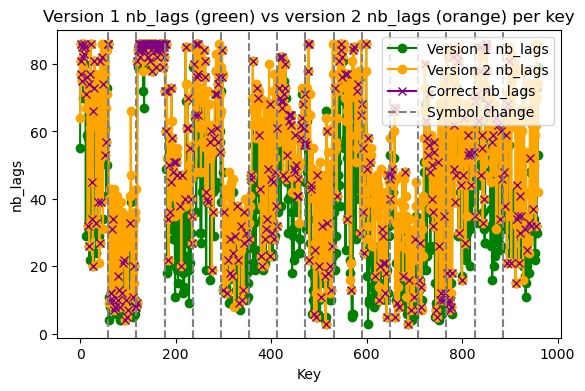


3. Average difference of nb_lags when incorrect: 21.68 (abs) | -21.19 (signed) | std: 14.53 | (detail per symbol below)
    XRPUSDT: 19.93 (abs) | -19.11 (signed) | std: 13.12
    OOKIUSDT: 24.06 (abs) | -24.06 (signed) | std: 7.36
    SOLUSDT: 6.0 (abs) | -5.25 (signed) | std: 5.17
    BCHUSDT: 19.44 (abs) | -19.44 (signed) | std: 10.48
    DOGEUSDT: 18.47 (abs) | -18.47 (signed) | std: 9.87
    JUVUSDT: 16.08 (abs) | -15.77 (signed) | std: 7.52
    TRXUSDT: 27.78 (abs) | -27.67 (signed) | std: 13.91
    SHIBUSDT: 14.64 (abs) | -14.24 (signed) | std: 8.96
    HBARUSDT: 25.65 (abs) | -25.45 (signed) | std: 13.52
    ICPUSDT: 23.95 (abs) | -22.9 (signed) | std: 18.93
    XLMUSDT: 20.0 (abs) | -19.1 (signed) | std: 11.54
    CITYUSDT: 15.84 (abs) | -15.44 (signed) | std: 8.57
    IMXUSDT: 39.75 (abs) | -39.56 (signed) | std: 22.38
    DOTUSDT: 16.65 (abs) | -16.18 (signed) | std: 11.15
    ETCUSDT: 19.26 (abs) | -19.09 (signed) | std: 9.69
    NEARUSDT: 26.47 (abs) | -24.6 (signed) | st

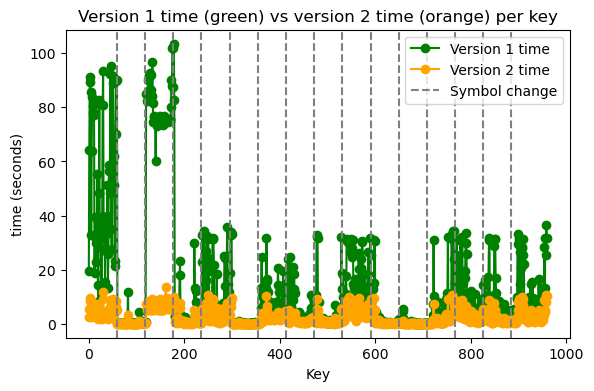

In [27]:
compare_ar_selection_versions(dic_ref, dic_mystic_opti_2)
# Display symbols in ascending order of median number of trades per day
# Allow to select only some symbols for comparison

In [7]:
signs = sign_extractor.retrieve_signs(symbols[1], dates_jan_2024[1], dates_jan_2024[1])[:250000]
print(len(signs))

ar_model = autoregressive_model.AutoregressiveModel(signs, nb_lags=None)
print(ar_model.select_model_nb_lags("statsmodels"))


225913
81


In [49]:
def ar_select_order_scipy_opti_minimize(signs, ic: Literal['aic', 'bic', 'hqic']="aic", init_pct=1):
    max_lag = int(np.ceil(12.0 * np.power(len(signs) / 100.0, 1 / 4.0)))

    x, y = lagmat(signs, max_lag, original="sep")
    x = sm.add_constant(x)
    y = y[max_lag:]
    x = x[max_lag:]
    x_pd = pd.DataFrame(x)

    nb_lags_to_ic = {}
    def objective_function(nb_lags):
        nb_lags = round(nb_lags[0])
        print(f" => {nb_lags}", end="")
        if (nb_lags in nb_lags_to_ic):
            return nb_lags_to_ic[nb_lags]
        
        x_selection = x_pd.values[:, slice(nb_lags)]

        ols_model = linear_models.OLS(y, x_selection)
        ols_model.df_model = x_selection.shape[1] - 1
        ols_model.k_constant = 1

        res = ols_model.fit()
        info_criteria = res.info_criteria(ic)

        nb_lags_to_ic[nb_lags] = info_criteria
        return info_criteria

    bound = ((1, max_lag + 1),)
    initial_value = min(round(init_pct * (max_lag + 1) / 2) if (init_pct is not None and init_pct != 0) else 1, max_lag + 1)

    print(f"init_pct: {init_pct} | Start at {initial_value} (max_lag: {max_lag})\n   ", end="")
    res = minimize(objective_function, initial_value, method="Powell", bounds=bound, tol=1)
    return round(res.x[0]) - 1

import mystic as my
def ar_select_order_mystic_opti(signs, ic: Literal['aic', 'bic', 'hqic'] = "aic", init_pct=1):
    max_lag = int(np.ceil(12.0 * np.power(len(signs) / 100.0, 1 / 4.0)))

    x, y = lagmat(signs, max_lag, original="sep")
    x = sm.add_constant(x)
    y = y[max_lag:]
    x = x[max_lag:]
    x_pd = pd.DataFrame(x)

    nb_lags_to_ic = {}
    def objective_function(nb_lags):
        nb_lags = nb_lags[0]
        print(f" => {nb_lags}", end="")
        if (nb_lags in nb_lags_to_ic):
            return nb_lags_to_ic[nb_lags]
        
        x_selection = x_pd.values[:, slice(nb_lags)]

        ols_model = linear_models.OLS(y, x_selection)
        ols_model.df_model = x_selection.shape[1] - 1
        ols_model.k_constant = 1

        res = ols_model.fit()
        info_criteria = res.info_criteria(ic)
        
        nb_lags_to_ic[nb_lags] = info_criteria
        return info_criteria
     
    integer_constraint = my.constraints.integers()(lambda x:x)
    initial_value = min(round(init_pct * (max_lag + 1) / 2) if init_pct != 0 else 1, max_lag + 1)
    if (type(init_pct) == float and init_pct == 2.0):
        assert(initial_value == max_lag + 1)
        print("assert")
    print(f"init_pct: {init_pct} | Start at {initial_value} (max_lag: {max_lag})\n   ", end="")
    result = my.solvers.fmin(objective_function, [initial_value], bounds=[(1, max_lag + 1)], xtol=1, maxiter=max_lag + 1, constraints=integer_constraint, disp=False)
    return round(result[0]) - 1

In [50]:
for init_pct in [0, 0.2, 0.4, 0.6, 0.8, 1, 1.25, 2.0][-1:]:
    s = time.time()
    nb_lags = ar_select_order_mystic_opti(signs, init_pct=init_pct)
    # nb_lags = ar_select_order_scipy_opti_minimize(signs, init_pct=init_pct)
    e = time.time()
    print(f"\n    NB_LAGS: {nb_lags} (time: {round(e - s, 1)} s)\n")

# init_pct: 0 | Start at 1 (max_lag: 83)
#     => 1 => 5 => 9 => 13 => 21 => 29 => 45 => 61 => 45 => 77 => 69 => 61 => 73 => 77 => 71 => 69 => 72 => 70 => 72 => 72 => 70 => 71
#     NB_LAGS: 70 (time: 22.4 s)

# init_pct: 0.2 | Start at 8 (max_lag: 83)
#     => 8 => 12 => 16 => 20 => 28 => 36 => 52 => 68 => 52 => 84 => 76 => 80 => 80 => 82 => 80 => 83 => 81 => 82
#     NB_LAGS: 81 (time: 25.5 s)

assert
init_pct: 2.0 | Start at 84 (max_lag: 83)
    => 84 => 80 => 82 => 80 => 83 => 81 => 82
    NB_LAGS: 81 (time: 12.6 s)



In [41]:
versions = ["statsmodels", "opti", "multi_processes", "scipy_opti_minimize_scalar", "scipy_opti_minimize", "mystic_opti", "perso_opti"]
ar_model = autoregressive_model.AutoregressiveModel(signs[:], nb_lags=None)
for version in versions:
    s = time.time()
    nb_lags = ar_model.select_model_nb_lags(version)
    e = time.time()
    print(f"{nb_lags} in {round(e - s, 2)} s ({version})")


82 in 71.78 s (statsmodels)
82 in 50.64 s (opti)
82 in 33.86 s (multi_processes)
82 in 13.98 s (scipy_opti_minimize_scalar)
78 in 9.42 s (scipy_opti_minimize)
82 in 13.36 s (mystic_opti)
82 in 57.07 s (perso_opti)


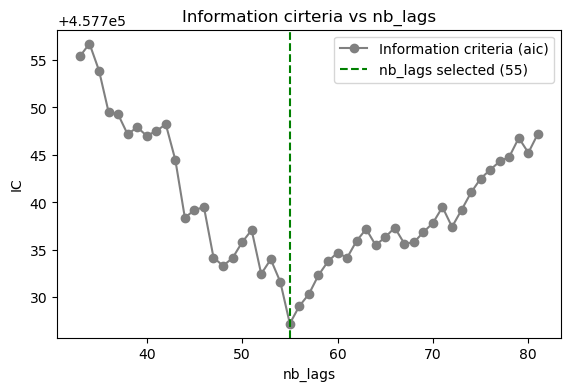

In [ ]:
def plot_ic_all_lags(y, max_lag: int | None = None, ic: Literal["aic", "bic", "hqic"] = "aic"):
    if (max_lag is None):
        # Schwert (1989)
        max_lag = int(np.ceil(12.0 * np.power(len(y) / 100.0, 1 / 4.0)))

    x, y = lagmat(y, max_lag, original="sep")
    x = sm.add_constant(x)
    y = y[max_lag:]
    x = x[max_lag:]
    x_pd = pd.DataFrame(x)

    ics = []
    ics_to_plot = []
    for i in range(max_lag + 1):
        x_selection = x_pd.values[:, slice(i + 1)]

        ols_model = linear_models.OLS(y, x_selection)
        ols_model.df_model = x_selection.shape[1] - 1
        ols_model.k_constant = 1

        res = ols_model.fit()
        
        lags = tuple(j for j in range(1, i + 1))
        lags = 0 if not lags else lags
        ics.append((lags, res.info_criteria(ic)))
        ics_to_plot.append(res.info_criteria(ic))
    
    selected_tuple = min(ics, key=lambda x: x[1])
    selected_lags = selected_tuple[0]
    nb_lags = len(selected_lags)

    skip_first_n_lags = 32
    nb_lags_to_plot = list(range(max(0, skip_first_n_lags + 1), max_lag + 1))
    if (nb_lags <= skip_first_n_lags):
        print(f"GREEN LINE WILL NOT BE SHOWN BECAUSE SELECTED NB_LAG ({nb_lags}) <= skip_first_n_lags ({skip_first_n_lags})")
    fig, axe = plt.subplots(1, 1, figsize=(6.5, 4))
    axe.plot(nb_lags_to_plot, ics_to_plot[skip_first_n_lags + 1:], color="grey", marker="o", label=f"Information criteria ({ic})")
    axe.axvline(x=nb_lags, color='green', label=f"nb_lags selected ({nb_lags})", linestyle='--')
    axe.set_title("Information cirteria vs nb_lags")
    axe.set_xlabel("nb_lags")
    axe.set_ylabel("IC")
    axe.legend()
    plt.show()
    return nb_lags

nb_lags = plot_ic_all_lags(signs)